This notebook pulls in the JSON from the getData.activities app file. I've saved the data locally for ease of use but you can either call the class into this notebook or incorporate some cells from this notebook into the main app as an additional class.
The rest of the notebook cleans and organizes the activities data and then trials some visualisations and applications

In [1]:
# Import packages
import pandas as pd
import json
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
import sklearn

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings("ignore")

/Users/douglasbudge/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Select fields of interest for the dataframe and format datetime
data = open("data.json","r")
activities = json.loads(data.read())
df= pd.DataFrame(activities)
df= df[["athlete","name","distance","moving_time","elapsed_time","start_latlng","total_elevation_gain","type","average_temp","start_date_local","location_city","location_country","kudos_count","average_speed","max_speed","has_heartrate","average_heartrate","max_heartrate","elev_high","elev_low","pr_count"]]
df['start_date_local']=pd.to_datetime(df['start_date_local'])
df['start_time']=df['start_date_local'].dt.time
df['start_date']=df['start_date_local'].dt.date
df['start_date']=pd.to_datetime(df['start_date'])
df['start_time']= pd.to_datetime(df['start_time'], format='%H:%M:%S')
df.head(5)

,athlete,name,distance,moving_time,elapsed_time,start_latlng,total_elevation_gain,type,average_temp,start_date_local,...,average_speed,max_speed,has_heartrate,average_heartrate,max_heartrate,elev_high,elev_low,pr_count,start_time,start_date
0,"{'id': 41223837, 'resource_state': 1}",Morning Run,9123.6,2789,2843,"[51.54054220765829, -0.15161932446062565]",119.5,Run,NaN,2023-06-07 08:08:04+00:00,...,3.271,4.553,True,144.5,172.0,114.9,31.1,0,1900-01-01 08:08:04,2023-06-07
1,"{'id': 41223837, 'resource_state': 1}",Morning Ride,112765.0,19969,24624,"[51.24082714319229, -0.32408284954726696]",1541.0,Ride,15.0,2023-06-05 10:21:31+00:00,...,5.647,15.594,False,NaN,NaN,244.4,14.8,30,1900-01-01 10:21:31,2023-06-05
2,"{'id': 41223837, 'resource_state': 1}",Afternoon Swim,1200.0,1455,1705,[],0.0,Swim,NaN,2023-06-02 13:00:29+00:00,...,0.825,5.797,False,NaN,NaN,NaN,NaN,0,1900-01-01 13:00:29,2023-06-02
3,"{'id': 41223837, 'resource_state': 1}",Lunch Run,16040.2,4445,4512,"[51.54071470722556, -0.15175343491137028]",140.9,Run,NaN,2023-06-01 11:53:27+00:00,...,3.609,6.012,True,158.7,186.0,114.9,29.0,7,1900-01-01 11:53:27,2023-06-01
4,"{'id': 41223837, 'resource_state': 1}",Morning Run,10250.1,3375,3413,"[51.54023543000221, -0.151614211499691]",136.6,Run,NaN,2023-05-31 07:22:34+00:00,...,3.037,5.327,True,134.7,156.0,114.9,31.1,6,1900-01-01 07:22:34,2023-05-31


In [3]:
#Separate the acitivities into types
df=df.loc[df['type']!= "Swim"]
df["pace"]= df["average_speed"]*3.6
df.reset_index(inplace=True)

runs= df.loc[df["type"]=="Run"]
runs['pace']= 1000/(runs["average_speed"]*60)
short_runs= runs.loc[df["distance"] <= 10000]
runs.reset_index(inplace=True)

rides=df.loc[df["type"]=="Ride"]
rides["pace"]= rides["average_speed"]*3.6
rides.reset_index(inplace=True)

Now we have the dataframes and fields of interest, we can explore some visualisations.
Elevation
- Am I slower when there is more elevation?
- Does elevation affect my run or bike more?
- Is there a threshold level of elevation where performance drops a lot?

Length of time
- How much affect do longer workouts have on my pace?
- If I take a period of rest, how much condition do I lose?

Kudos
- Which of my runs get the most kudos?
- What are the key features of my most liked workouts?


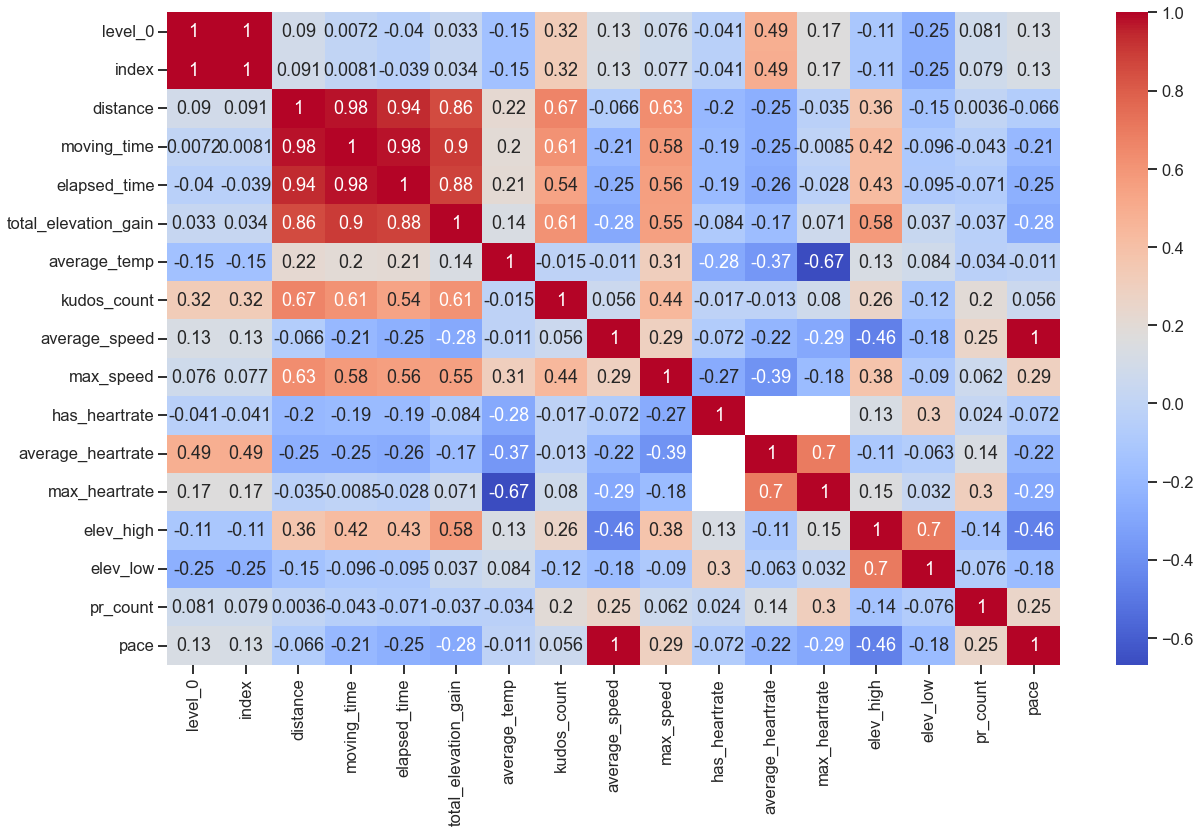

In [27]:
# Firstly I should sense check my assumption that distance and time are most important for my average speed. 
# A quick check of a correlation matrix should confirm this.
plt.figure(figsize=(20,12))
sns.heatmap(rides.corr(), annot=True, cmap='coolwarm')
plt.show()


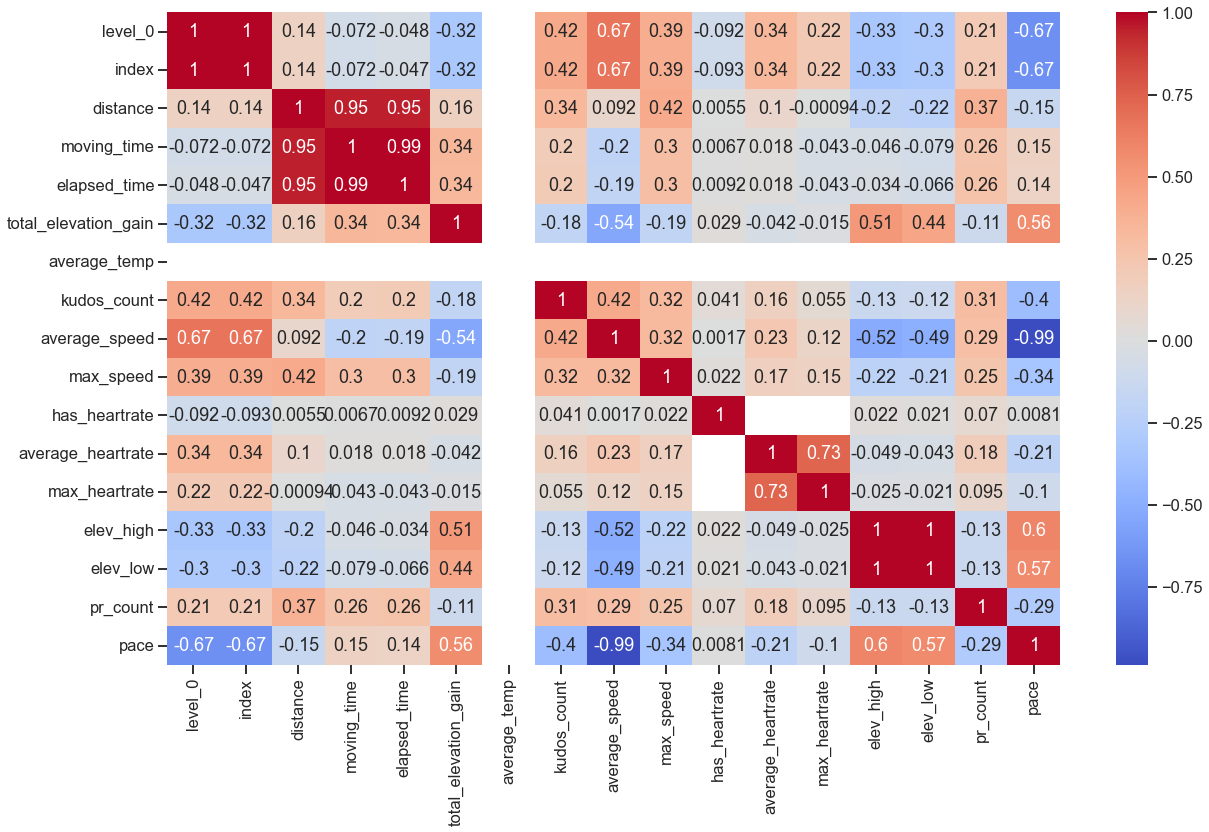

In [28]:
plt.figure(figsize=(20,12))
sns.heatmap(runs.corr(), annot=True, cmap='coolwarm')
plt.show()


In [35]:
run_corr_matrix = runs.corr()
print(run_corr_matrix["pace"].sort_values(ascending=False))

pace                    1.000000
elev_high               0.597274
elev_low                0.569011
total_elevation_gain    0.558780
moving_time             0.149167
elapsed_time            0.137606
has_heartrate           0.008063
max_heartrate          -0.100639
distance               -0.146440
average_heartrate      -0.210683
pr_count               -0.286481
max_speed              -0.342487
kudos_count            -0.403625
level_0                -0.666680
index                  -0.666695
average_speed          -0.988125
average_temp                 NaN
Name: pace, dtype: float64


In [34]:
ride_corr_matrix = rides.corr()
print(ride_corr_matrix["pace"].sort_values(ascending=False))

pace                    1.000000
average_speed           1.000000
max_speed               0.292462
pr_count                0.254629
level_0                 0.127154
index                   0.125959
kudos_count             0.055979
average_temp           -0.010601
distance               -0.066312
has_heartrate          -0.072242
elev_low               -0.183067
moving_time            -0.205862
average_heartrate      -0.222548
elapsed_time           -0.245343
total_elevation_gain   -0.282937
max_heartrate          -0.285210
elev_high              -0.462181
Name: pace, dtype: float64


Text(0.5, 1.0, 'Average Speed vs elevation')

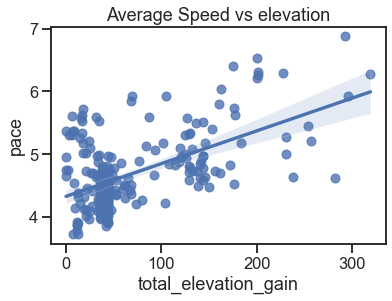

In [4]:
sns.set(style="ticks", context="talk")
sns.regplot(x='total_elevation_gain', y = 'pace', data = runs).set_title("Average Speed vs elevation")

In [5]:
def print_boxplot(type_data,feature, figsize=(14, 10)):
    data = pd.concat([type_data['pace'], type_data[feature]], axis=1)
    f, ax = plt.subplots(figsize=figsize)
    fig = sns.boxplot(x=feature, y="pace", data=data)

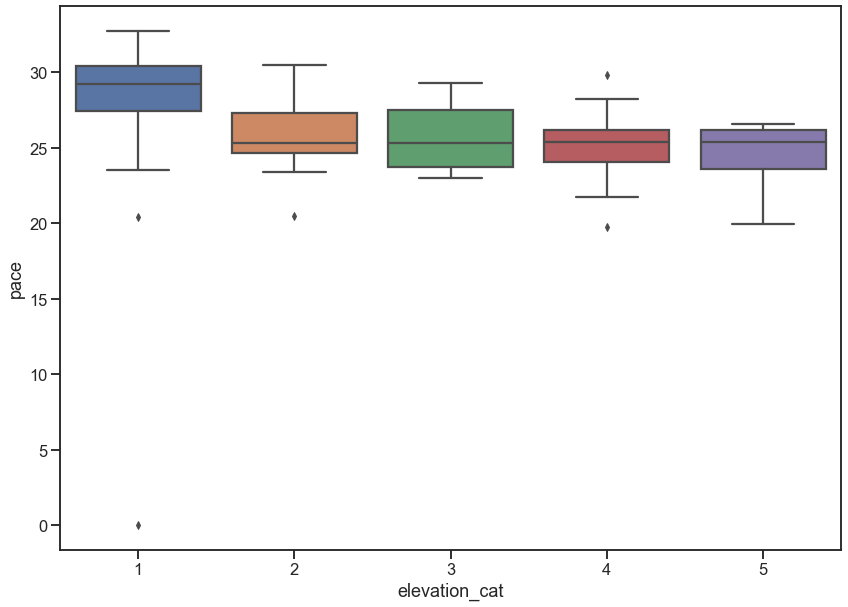

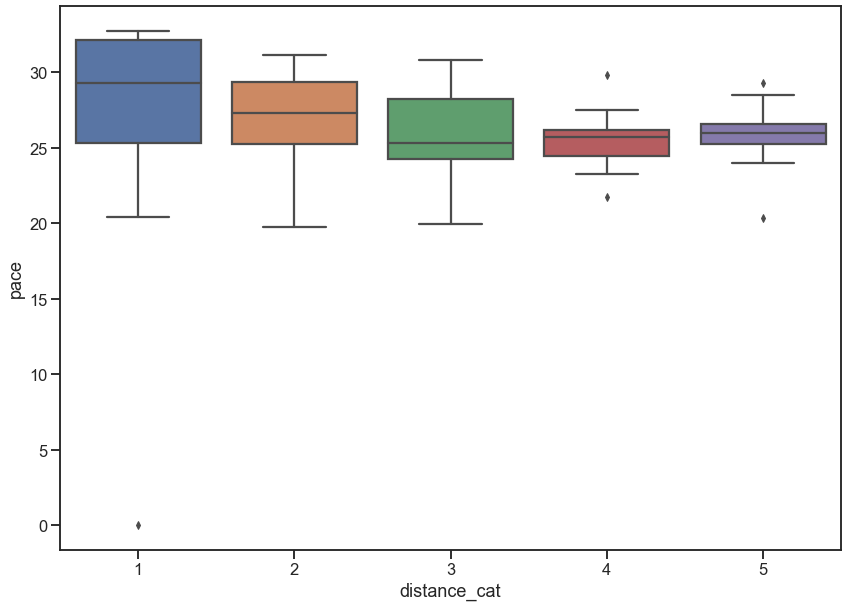

In [6]:
#Too many different elevations so group them.
rides["elevation_cat"]= pd.cut(
    rides.total_elevation_gain,
    bins=5,
    labels=[1,2,3,4,5]
)
print_boxplot(rides,'elevation_cat')
# Let's check the same for distance
rides["distance_cat"]= pd.cut(
    rides.distance,
    bins=5,
    labels=[1,2,3,4,5]
)
print_boxplot(rides,'distance_cat')

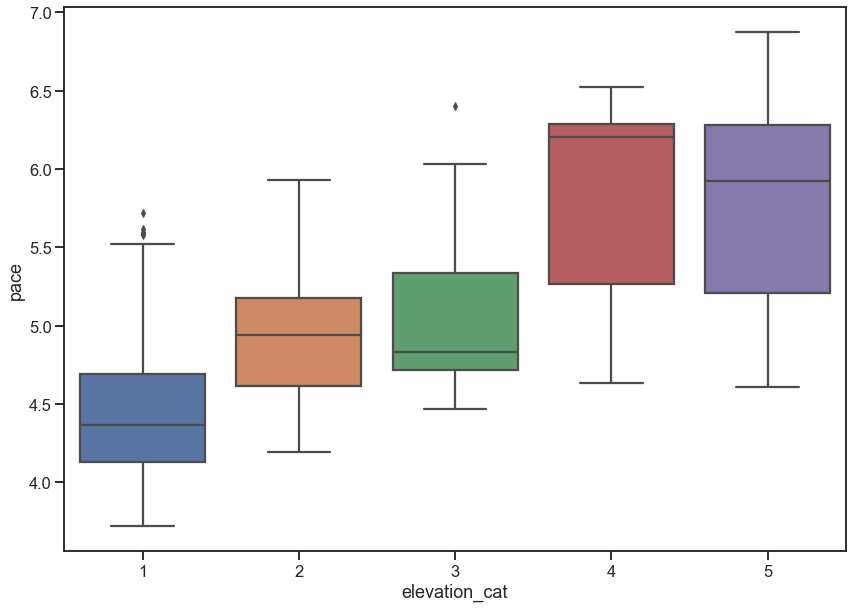

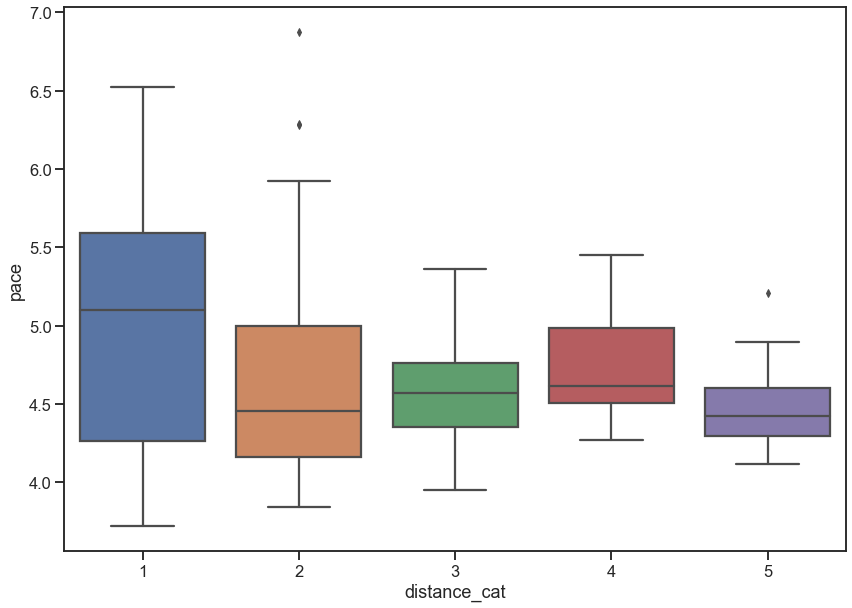

In [7]:
#Is it the same for running?
runs["elevation_cat"]= pd.cut(
    runs.total_elevation_gain,
    bins=5,
    labels=[1,2,3,4,5]
)
runs["distance_cat"]= pd.cut(
    runs.distance,
    bins=5,
    labels=[1,2,3,4,5]
)
print_boxplot(runs,'elevation_cat')
print_boxplot(runs,'distance_cat')

Text(0.5, 1.0, 'Average Speed vs Distance on Short Runs (<10,000)')

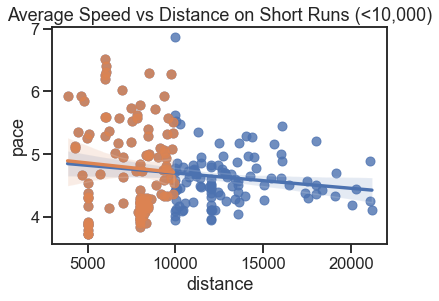

In [8]:
sns.set(style="ticks", context="talk")
sns.regplot(x='distance', y = 'pace', data = runs).set_title("Average Speed vs Distance")

sns.set(style='ticks', context='talk')
sns.regplot(x='distance',y='pace',data=short_runs).set_title("Average Speed vs Distance on Short Runs (<10,000)")

It looks like distance and elevation affect my runs and bikes. Time to quantify the relationships so I can answer does elevation affect my run or my bike pace more? Does distance affect my run or my bike more? Are there threshold levels where my performance deteriorates?

Because I'm examining the relationship between independent variables (distance and elevation) and a dependent variable (average speed) I have a few options for modelling the relationship. The sample is relatively small so I don't want to select any complex or deep ML models. If accurate prediction was the most important consideration then I might pre-train a deep learning model and then fit it to my additional data but this would be laborious, and would of course be difficult to interrogate the relationship which is what I really care about.

From traditional statistics I can check linear and nonlinear regression. There are other traditional statistical options like GLM but some simple regression should serve as a starting point.
From the ML field I'll check a SVR, XGBoost and Random Forest Regressor.

I want to form a view of how difficult any activity should be for me based on distance and elevation. From there I can weight my performances over time.

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
regr=LinearRegression()
model = Pipeline([
  ('poly', PolynomialFeatures(degree=2)),
  ('linear', LinearRegression(fit_intercept=False))
])

X=runs[["distance","total_elevation_gain"]]
y=runs["pace"]
regr.fit(X,y)
model.fit(X,y)
print("distance and elevation coefficients for running: {}, R-squared of: {}".format(regr.coef_,regr.score(X,y)))
print("R-squared of polynomial regression for running: {}".format(model.score(X,y)))

X=rides[["distance","total_elevation_gain"]]
y=rides["pace"]
regr.fit(X,y)
model.fit(X,y)
print("distance and elevation coefficients for riding: {}, R-squared of: {}".format(regr.coef_,regr.score(X,y)))
print("R-squared of polynomial regression for riding: {}".format(model.score(X,y)))

distance and elevation coefficients for running: [-3.98146875e-05  5.57092716e-03], R-squared of: 0.3679626541244728
R-squared of polynomial regression for running: 0.4327758237410617
distance and elevation coefficients for riding: [ 9.03368505e-05 -7.80417101e-03], R-squared of: 0.19566682550360692
R-squared of polynomial regression for riding: 0.33403768908829734


In [ ]:
#SVR

#Random Forest

#XGBoost

I could try to wrangle the data more but while I am still trying to settle on a method for measuring my course-relative fitness over time I want to move quickly.

### Training over time ###

*Now I have examined my individual workouts I want to look at my training.*
- Is there a number/intensity/consistency of workouts which means I bike or run faster on average? Maybe I do the same workouts with less effort? 
- Is there a number/intensity/consistency of workouts where I lose condition? 

To answer both these questions, first I need a metric of my fitness. A course-adjusted moving average of my pace or effort

/var/folders/_s/k6zmybnj6j1cgzb3bwm8bkym0000gn/T/ipykernel_13838/791461470.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


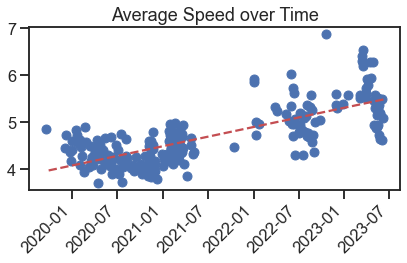

In [ ]:
fig = plt.figure() #create overall container
ax1 = fig.add_subplot(111) #add a 1 by 1 plot to the figure
x = np.asarray(runs.start_date)  #convert data to numpy array
y = np.asarray(runs.pace)
ax1.plot_date(x, y) #plot data points in scatter plot on ax1
ax1.set_title('Average Speed over Time')
#ax1.set_ylim([0,5])

#add trend line
x2 = mdates.date2num(x)
z=np.polyfit(x2,y,1)
p=np.poly1d(z)
plt.plot(x,p(x2),'r--')

#format the figure and display
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()

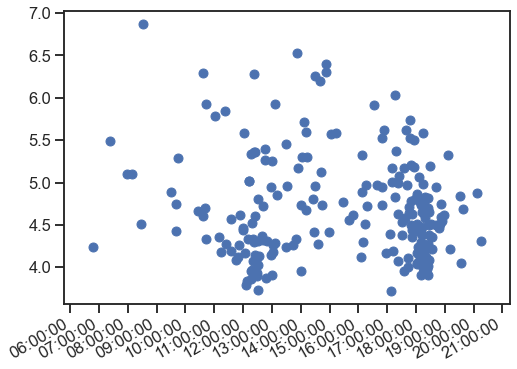

In [ ]:
'''
fig = plt.figure() #create overall container
ax1 = fig.add_subplot(111) #add a 1 by 1 plot to the figure
x = np.asarray(runs.start_time)  #convert data to numpy array
y = np.asarray(runs.pace)
ax1.plot(x, y) #plot data points in scatter plot on ax1
ax1.set_title('Average Speed over Time')
#ax1.set_ylim([0,5])

#add trend line

x2 = mdates.date2num(x)
z=np.polyfit(x2,y,1)
p=np.poly1d(z)
plt.plot(x,p(x2),'r--')
'''

#format the figure and display
fig, ax = plt.subplots(figsize=(8,6))
x = np.asarray(runs.start_time)  #convert data to numpy array
y = np.asarray(runs.pace)

ax.plot_date(x,y)
ax.set_xlim(runs['start_time'].min()-pd.Timedelta(1,'h'),
            runs['start_time'].max()+pd.Timedelta(1,'h'))

ax.xaxis.set_major_locator(md.HourLocator(interval = 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))

fig.autofmt_xdate()

plt.show()